In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11
#plt.rcParams['text.usetex'] = True

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
#with open("../../config.yaml", "r") as f:
#    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt
import writing_tools as wt

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False


In [2]:
# ---- Basic stats and numbers

items = dt.get_items()
items = items.loc[items['invoiceActionState']!='FAILED'].reset_index(drop=True)
NumItems = len(items)

posts = dt.get_posts()
posts = posts.loc[posts['invoiceActionState']!='FAILED'].reset_index(drop=True)
NumPosts = len(posts)

comments = dt.get_comments()
comments = comments.loc[comments['invoiceActionState']!='FAILED'].reset_index(drop=True)
NumComments = len(comments)

assert NumItems == NumPosts + NumComments

NumUsers = items['userId'].nunique()
NumTerritories = items['subName'].nunique()

StartDate = globals.data_start.strftime("%B %d, %Y").replace(" 0", " ")
EndDate = globals.data_end.strftime("%B %d, %Y").replace(" 0", " ")
NonCustodialDate = globals.nc_date.strftime("%B %d, %Y").replace(" 0", " ")

zaps = dt.get_zaps()
TotalZaps = zaps['sats'].sum()
TotalCost = items['cost'].sum()

wt.update_results({
    "NumItems": f"{NumItems:,.0f}",
    "NumPosts": f"{NumPosts:,.0f}",
    "NumComments": f"{NumComments:,.0f}",
    "NumUsers": f"{NumUsers:,.0f}",
    "NumTerritories": f"{NumTerritories:,.0f}",
    "StartDate": StartDate,
    "EndDate": EndDate,
    "NonCustodialDate": NonCustodialDate,
    "TotalZaps": f"{np.round(TotalZaps/1e6):,.0f} million",
    "TotalCost": f"{np.round(TotalCost/1e6):,.0f} million"
})

{'PostsCostElasticity': '-0.265',
 'PostsCostDoublingEffect': '16.8',
 'Zaps48CostElasticity': '0.219',
 'Zaps48CostDoublingEffect': '16.4',
 'Comments48CostElasticity': '0.043',
 'Comments48CostDoublingEffect': '3.0',
 'NumItems': '1,121,485',
 'NumPosts': '207,219',
 'NumComments': '914,266',
 'NumUsers': '11,228',
 'NumTerritories': '117',
 'StartDate': 'June 11, 2021',
 'EndDate': 'October 5, 2025',
 'TotalZaps': '146 million',
 'NonCustodialDate': 'January 3, 2025',
 'TotalCost': '13 million',
 'Sats48': '94',
 'Comments48': '90',
 'NumPostingFeeChanges': '199',
 'AvgPostingCost': '51',
 'AvgSats48': '364',
 'AvgComments48': '3.3',
 'SdPostingCost': '241',
 'SdSats48': '6,662',
 'SdComments48': '9.6',
 'AvgPostingCostCents': '5',
 'NumberHighQuality': '44,682',
 'NumberLowQuality': '146,652'}

c:\Users\edwar\projects\sn-research\src\notebooks\../python\data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time
c:\Users\edwar\projects\sn-research\src\notebooks\../python\data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time


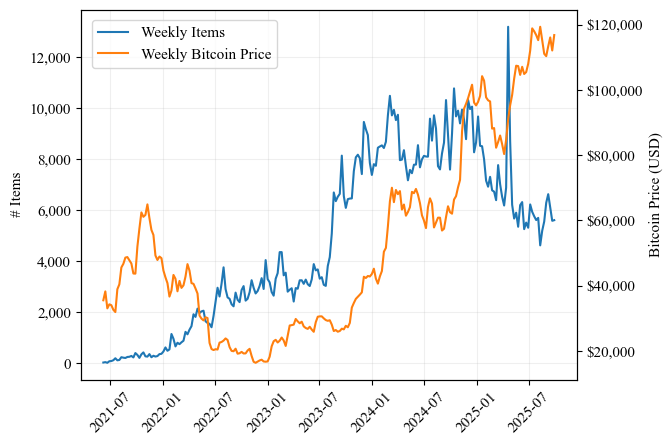

In [3]:
# Plot stacker news item count

items['week'] = dt.as_week(items['created_at'])
mask = (items['invoiceActionState'] != 'FAILD') & \
       (items['userId']!=globals.spammer_id) & \
       (items['week'] < items['week'].max())
items_wk = items.loc[mask].groupby('week').agg(
    num_items = ('itemId', 'count')
).reset_index()

price_wk = dt.get_price_weekly()
items_wk = items_wk.merge(price_wk, on='week', how='left')

fig, ax1 = plt.subplots()
fig.figsize = (6,4)
ax1.plot(items_wk['week'], items_wk['num_items'], label='Weekly Items', color='tab:blue')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('# Items')
ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
ax1.grid(alpha=0.2)

ax2 = ax1.twinx()
ax2.plot(items_wk['week'], items_wk['btc_price'], label='Weekly Bitcoin Price', color='tab:orange')
ax2.set_ylabel('Bitcoin Price (USD)')
ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

fig.legend(loc='upper left', bbox_to_anchor=(0.13, 0.875))

plt.savefig(os.path.join(LOCAL_PATH, 'results', 'fig_weekly_items.pdf'), format='pdf', bbox_inches='tight')
plt.show()


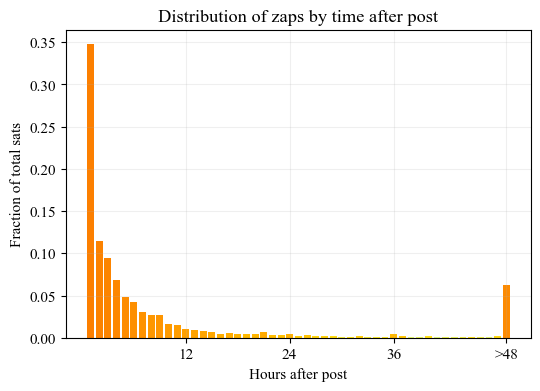

{'PostsCostElasticity': '-0.265',
 'PostsCostDoublingEffect': '16.8',
 'Zaps48CostElasticity': '0.219',
 'Zaps48CostDoublingEffect': '16.4',
 'Comments48CostElasticity': '0.043',
 'Comments48CostDoublingEffect': '3.0',
 'NumItems': '1,121,485',
 'NumPosts': '207,219',
 'NumComments': '914,266',
 'NumUsers': '11,228',
 'NumTerritories': '117',
 'StartDate': 'June 11, 2021',
 'EndDate': 'October 5, 2025',
 'TotalZaps': '146 million',
 'NonCustodialDate': 'January 3, 2025',
 'TotalCost': '13 million',
 'Sats48': '94',
 'Comments48': '90',
 'NumPostingFeeChanges': '199',
 'AvgPostingCost': '51',
 'AvgSats48': '364',
 'AvgComments48': '3.3',
 'SdPostingCost': '241',
 'SdSats48': '6,662',
 'SdComments48': '9.6',
 'AvgPostingCostCents': '5',
 'NumberHighQuality': '44,682',
 'NumberLowQuality': '146,652'}

In [4]:
# ---- Show distribution of zaps in first 48 hours

zaps = dt.get_zaps()
posts = dt.get_posts()

# select posts to consider
mask = (posts['invoiceActionState'] != 'FAILED') & \
       (~posts['bio']) & (~posts['freebie']) & (~posts['saloon']) & \
       (posts['subName'].notnull()) & (posts['subName'] != '') & \
       (~posts['subName'].isin(['jobs', 'ama']))
posts = posts.loc[mask].reset_index(drop=True)

# get post creation times
right = posts[['itemId', 'created_at']].rename(
    columns = {'created_at': 'post_created_at'}
).reset_index(drop=True)

# append post creation times to zaps
zaps = zaps.merge(right, on='itemId', how='inner')

# hours after post for zaps
zaps['hours_after_post'] = np.ceil((zaps['zap_time'] - zaps['post_created_at']).dt.total_seconds() / 3600)
zaps['hours_after_post'] = zaps['hours_after_post'].clip(upper=49)

# plot distribution by hour
hours = zaps.groupby(['hours_after_post']).agg(
    sats = ('sats', 'sum')
).reset_index()
hours['frac'] = hours['sats'] / hours['sats'].sum()
hours = hours.sort_values(by='frac', ascending=True).reset_index(drop=True)
colors = plt.cm.Wistia(np.linspace(0.0,1,len(hours)))
plt.figure(figsize=(6,4))
plt.bar(hours['hours_after_post'], hours['frac'], color=colors)
plt.xticks(ticks=[12, 24, 36, 49], labels=['12', '24', '36', '>48'])
plt.xlabel('Hours after post')
plt.ylabel('Fraction of total sats')
plt.grid(alpha=0.2)
plt.title('Distribution of zaps by time after post')
plt.show()

wt.update_results({
    'Sats48': f"{hours.loc[hours['hours_after_post']<=48, 'frac'].sum()*100:,.0f}",
})

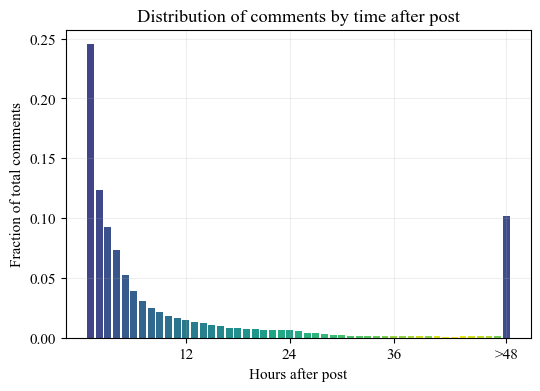

{'PostsCostElasticity': '-0.265',
 'PostsCostDoublingEffect': '16.8',
 'Zaps48CostElasticity': '0.219',
 'Zaps48CostDoublingEffect': '16.4',
 'Comments48CostElasticity': '0.043',
 'Comments48CostDoublingEffect': '3.0',
 'NumItems': '1,121,485',
 'NumPosts': '207,219',
 'NumComments': '914,266',
 'NumUsers': '11,228',
 'NumTerritories': '117',
 'StartDate': 'June 11, 2021',
 'EndDate': 'October 5, 2025',
 'TotalZaps': '146 million',
 'NonCustodialDate': 'January 3, 2025',
 'TotalCost': '13 million',
 'Sats48': '94',
 'Comments48': '90',
 'NumPostingFeeChanges': '199',
 'AvgPostingCost': '51',
 'AvgSats48': '364',
 'AvgComments48': '3.3',
 'SdPostingCost': '241',
 'SdSats48': '6,662',
 'SdComments48': '9.6',
 'AvgPostingCostCents': '5',
 'NumberHighQuality': '44,682',
 'NumberLowQuality': '146,652'}

In [5]:
# ---- Show distribution of comments in first 48 hours

comments = dt.get_comments()
posts = dt.get_posts()

# select posts to consider
mask = (posts['invoiceActionState'] != 'FAILED') & \
       (~posts['bio']) & (~posts['freebie']) & (~posts['saloon']) & \
       (posts['subName'].notnull()) & (posts['subName'] != '') & \
       (~posts['subName'].isin(['jobs', 'ama']))
posts = posts.loc[mask].reset_index(drop=True)

# select comments to consider
mask = (comments['invoiceActionState'] != 'FAILED')
comments = comments.loc[mask].reset_index(drop=True)

# get post creation times
right = posts[['itemId', 'created_at']].rename(
    columns = {'itemId': 'rootId', 'created_at': 'post_created_at'}
).reset_index(drop=True)

# append post creation times to zaps
comments = comments.merge(right, on='rootId', how='inner')

# hours after post for zaps
comments['hours_after_post'] = np.ceil((comments['created_at'] - comments['post_created_at']).dt.total_seconds() / 3600)
comments['hours_after_post'] = comments['hours_after_post'].clip(upper=49)

# plot distribution by hour
hours = comments.groupby(['hours_after_post']).agg(
    n_comments = ('itemId', 'count')
).reset_index()
hours['frac'] = hours['n_comments'] / hours['n_comments'].sum()
hours = hours.sort_values(by='frac', ascending=True).reset_index(drop=True)
colors = plt.cm.viridis_r(np.linspace(0.0,0.8,len(hours)))
plt.figure(figsize=(6,4))
plt.bar(hours['hours_after_post'], hours['frac'], color=colors)
plt.xticks(ticks=[12, 24, 36, 49], labels=['12', '24', '36', '>48'])
plt.xlabel('Hours after post')
plt.ylabel('Fraction of total comments')
plt.grid(alpha=0.2)
plt.title('Distribution of comments by time after post')
plt.show()

wt.update_results({
    'Comments48': f"{hours.loc[hours['hours_after_post']<=48, 'frac'].sum()*100:,.0f}",
})

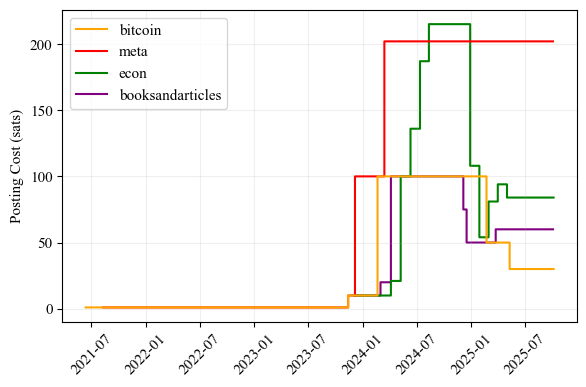

In [6]:
# territory posting cost history figure

fees_df = dt.get_territory_post_fee_histories()

subs = ['bitcoin', 'meta', 'econ', 'booksandarticles']
colors = ['orange', 'red', 'green', 'purple']

plt.figure(figsize=(6,4))
for i in range(len(subs)):
    sub = subs[i]
    color = colors[i]
    zorder = 3 - i
    x = fees_df.loc[fees_df['subName']==sub, 'date']
    y = fees_df.loc[fees_df['subName']==sub, 'posting_fee']
    plt.step(x, y, where='post', label=sub, color=color, zorder=zorder)

plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.2)
plt.ylabel('Posting Cost (sats)')
#plt.title("Territory Posting Fee Histories")
plt.tight_layout()
plt.savefig(os.path.join(LOCAL_PATH, 'results', 'fig_territory_posting_fees.pdf'), format='pdf', bbox_inches='tight')
plt.show()

In [7]:
# count territory posting fee changes
n_changes = 0
currsub = ''
fee = 0
for idx, row in fees_df.iterrows():
    sub = row['subName']
    if sub != currsub:
        currsub = sub
        fee = row['posting_fee']
    elif row['posting_fee'] != fee:
        n_changes += 1
        fee = row['posting_fee']

wt.update_results({
    'NumPostingFeeChanges': f"{n_changes:,.0f}"
})


{'PostsCostElasticity': '-0.265',
 'PostsCostDoublingEffect': '16.8',
 'Zaps48CostElasticity': '0.219',
 'Zaps48CostDoublingEffect': '16.4',
 'Comments48CostElasticity': '0.043',
 'Comments48CostDoublingEffect': '3.0',
 'NumItems': '1,121,485',
 'NumPosts': '207,219',
 'NumComments': '914,266',
 'NumUsers': '11,228',
 'NumTerritories': '117',
 'StartDate': 'June 11, 2021',
 'EndDate': 'October 5, 2025',
 'TotalZaps': '146 million',
 'NonCustodialDate': 'January 3, 2025',
 'TotalCost': '13 million',
 'Sats48': '94',
 'Comments48': '90',
 'NumPostingFeeChanges': '199',
 'AvgPostingCost': '51',
 'AvgSats48': '364',
 'AvgComments48': '3.3',
 'SdPostingCost': '241',
 'SdSats48': '6,662',
 'SdComments48': '9.6',
 'AvgPostingCostCents': '5',
 'NumberHighQuality': '44,682',
 'NumberLowQuality': '146,652'}